---

# **Work done by Haithem DAGHMOURA & Kais ZAIRI**

---



This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

**Answers**

- **Infinite signal:** \
  The Discrete Time Fourier Transform (DTFT) of a two-dimensional signal a(n,m) is given by:
  $$\hat{a}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n, m) e^{-i2\pi (\nu_x n + \nu_y m)}
  $$

  $$\hat{b}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c, m+d) e^{-i2\pi (\nu_x n + \nu_y m)}
  $$

  We can rewrite $\hat{b}$ by change the variables in the summation to $n'=n+c$ and $m'=m+d$, then we have:

  \begin{align}
  \hat{b}(\nu_x, \nu_y) &= \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') e^{-i2\pi (\nu_x (n'-c) + \nu_y (m'-d))} \\
  &= e^{i2\pi (c\nu_x + d\nu_y)} \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') e^{-i2\pi (\nu_x n' + \nu_y m')} \\
  &= e^{i2\pi (c\nu_x + d\nu_y)} \hat{a}(\nu_x, \nu_y)
  \end{align}

  Thus,
  $$\frac{\hat{b}(\nu_x, \nu_y)}{\hat{a}(\nu_x, \nu_y)} = e^{i2\pi (c\nu_x + d\nu_y)}$$

- **Finite signal:** \

  The Discrete Fourier Transform (DFT) of a finite signal is given by:

  $$\hat{A}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n, m) \exp\left(-\frac{2i\pi(nk_x + mk_y)}{N}\right)
  $$

  $$\hat{B}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} b(n, m) \exp\left(-\frac{2i\pi(nk_x + mk_y)}{N}\right)
  $$

  To get a linear phase signal we can assume these hypotheses:

  - Translation: The signal $b(n,m)$ is a translated version of the signal $a(n,m)$. (Extension from the inifine signal case)
  - Periodicity: The signals $a$ and $b$ are periodic with period $N$ in both dimensions. This is because the DFT assumes that the signal is periodic.
  - Finite and Same Length: The signals a and b are finite and of the same length $N × N$.


## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [166]:
switch_image = False    # False -> 'ball.mat' image
                        # True  -> 'lena.mat' image


if not switch_image :
    im1 = loadmat('ball.mat')['im1']
    im1 = im1.astype('float')

else:
    im1 = loadmat('lena.mat')['im1']
    im1 = im1.astype('float')

N, M = np.shape(im1)

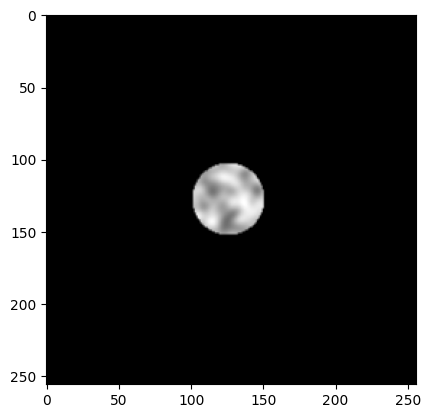

In [167]:
# Potentially add noise to the image
add_noise = False

if add_noise:
    sigma = 2
    im1 = np.clip(im1 + np.random.normal(0, sigma, im1.shape), 0, 255)      ## add noise + clip pixels values between 0 and 255

plt.figure(),plt.imshow(im1,cmap='gray'),plt.show();

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [168]:
def fracMc(ref,mvf,outofbound=20):

    [rows, cols] = np.shape(ref);



    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates

    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement

    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image

    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)

    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points


    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])


    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)

    motcomp =  griddata(points, values, points_inter,'linear')

    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))

    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py

    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy

    y = fracMc(x,mvf,out)
    return y

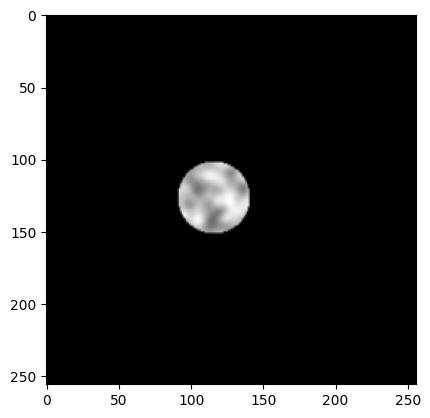

In [188]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.ones((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray'),plt.show();

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

To determine the translation parameters between two images, you initially compute the 2D Fast Fourier Transform (FFT) of both images. Following that, you calculate the phase of the ratio of these FFTs. This results in a phase plane. The slope of this plane, which corresponds to the translation parameters, can be estimated using methods such as the median of the gradient or least squares planar approximation.

In [189]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [190]:
def angle2D(x):
    a = np.angle(x)

    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]

    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [191]:
phi = angle2D(IM1 / IM2)

Display phi. Is it a linear plane and why?

**Answer:**

The plot below demonstrates that `phi` forms a linear plane. This is anticipated since  `im2` is a translated version of `im1`, thereby satisfying the theoretical prerequisite for the phase to form a linear plane, as given in the theoretical part.

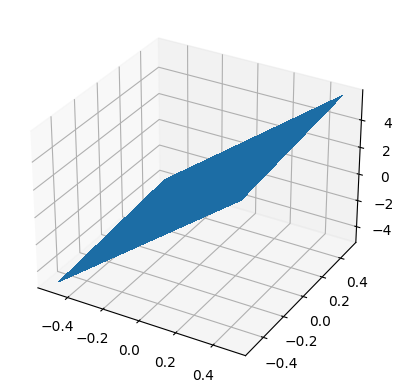

In [192]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [193]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.gradient(M, stepY, axis=0)
    gx = np.gradient(M, stepX, axis=1)


    return gx,gy

In [194]:
def gradient(M, stepX=1., stepY=1.):
    # Define the difference kernels
    kernel_x = np.array([[1, -1]])
    kernel_y = np.array([[1], [-1]])

    # Compute the gradients by convolving M with the kernels
    gx = convolve2d(M, kernel_x, mode='same') / stepX
    gy = convolve2d(M, kernel_y, mode='same') / stepY

    return gx, gy


In [195]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [196]:
print(GX)
print(GY)

10.0
1.0


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

This method estimates the translation parameters by fitting a plane to the phase difference matrix `phi` using the least squares method. The plane is defined by the equation `A * bEst = b`, where `A` contains the pixel coordinates, ``b` contains the phase values, and `bEst` contains the estimated translation parameters. The least squares solution minimizes the sum of the squared residuals, i.e., the differences between the observed and fitted phase values.


In [197]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))

    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [198]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [199]:
print(bEst)

[9.99981832 0.99999929]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**Answer**
(In order to view the result just set the value switch_image to True and re-run the previous section )
- With noise : `(c, d) = [9.53667774 1.03386819]`, the estimated translation parameters (c, d) are close to the expected values but not exact. This is likely due to the noise present in the image, which can distort the phase difference and make the plane fitting less accurate.

- Without noise : `(c, d) = [9.99981832 0.99999929]`, the estimated translation parameters (c, d) are very close to the expected values.

- With lena image : `(c, d) = [7.90761829 0.01702052]`, the estimated translation parameters (c, d) might be less accurate if the lena image has complex textures and structures that don't translate uniformly.

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [200]:
### Functions from the previous TP

def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of cols in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION. Motion vector field
    prediction : TYPE
        DESCRIPTION. The frame that we reconstitue

    """

    extension = search
    # pour tenir compte de fait que le mvt peut se diriger vers le dehors de l'image et éviter les if dans les bords
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect : copies the image in a slightly larger one and filling the boards

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;   # not necessary to scale

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for p in range (0,cur.shape[0],brow) : # for each block in the current image, find the best corresponding block in the reference image
            for q in range (0,cur.shape[1],bcol) :
                # current block selection

                B = cur[p:p+brow,q:q+bcol] # Block
                #print(f"p = {p}, q={q} ,brow= {brow},bcol={bcol}")
                # Initialization:

                costMin = (brow*bcol*255)**2

                Rbest = [0,0]

                # Loop on candidate displacement vectors
                for dcol in  range (q,q+2*search) : # dcol = candidate displacement vector over the columns
                    for drow in range (p,p+2*search) :# rcol = candidate displacement vector over the rows

                        current_block = ref_extended[drow:drow+brow,dcol:dcol+bcol]
                        current_cost = ((current_block-B)**2).sum()
                        if (current_cost <costMin) :# Save the results if they are better than the previous ones
                           #print(f"p = {p}, q={q}, current cost :{current_cost}, cost min : {costMin}, previous {(Rbest[0]-search,Rbest[1]-search)}, new {[drow-search,dcol-search]}")

                           costMin = current_cost
                           #print(f"costMin = {costMin}")
                           Rbest = [drow-search-p,dcol-search-q]
                #print(f"displacement : {Rbest} and costMin = {costMin}")

                mvf[p:p+brow,q:q+bcol,0]= Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf [p:p+brow,q:q+bcol,1]= Rbest[1]# Once the loop is over, save the best column displacement field
                prediction[p:p+brow,q:q+bcol]= ref_extended[p-Rbest[0]+search:p-Rbest[0]+search+brow,q-Rbest[1]+search:q-Rbest[1]+search+bcol]

    else: # Regularized search
        for p in range (0,cur.shape[0],brow) :# for each block in the current image, find the best corresponding block in the reference image
            for q in range (0,cur.shape[1],bcol) :
                # current block selection
                B = cur[p:p+brow,q:q+bcol] # Block

                # Initializations

                costMin =np.inf # largest value possible as init
                Rbest =  [0,0]

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(p,q,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol  in  range (q,q+2*search) : # dcol = candidate displacement vector over the columns
                    for drow in range (p,p+2*search) : # rcol = candidate displacement vector over the rows

                        #SAD(v)+lambda*error(v)
                        current_block = ref_extended[drow:drow+brow,dcol:dcol+bcol]
                        current_cost = ((current_block-B)**2).sum() +lamb*((pV-np.array([drow-search-p,dcol-search-q]))**2 ).sum() # here, encore the REGULARIZED cost function

                        if (current_cost <costMin) : # Save the results if they are better than the previous ones
                           #print(f"p = {p}, q={q}, current cost :{current_cost}, cost min : {costMin}, previous {(Rbest[0]-search,Rbest[1]-search)}, new {[drow-search,dcol-search]}")

                           costMin = current_cost
                           #print(f"costMin = {costMin}")
                           Rbest = [drow-search-p,dcol-search-q]


                mvf[p:p+brow,q:q+bcol,0]= Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[p:p+brow,q:q+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[p:p+brow,q:q+bcol]=ref_extended[p-Rbest[0]+search:p-Rbest[0]+search+brow,q-Rbest[1]+search:q-Rbest[1]+search+bcol]


    mvf = -mvf # For compatibility with standards

    return mvf, prediction

def displayMVF(I,mvf,subsamp):

    row,col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]

    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)

    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)


    return

10.0
1.0


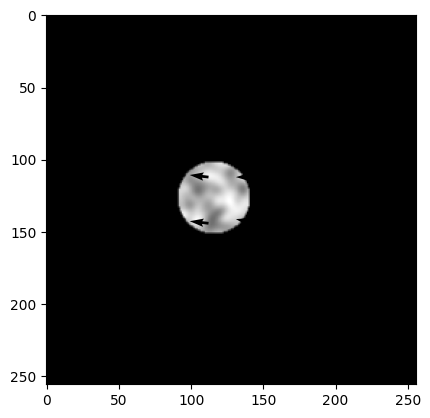

In [201]:
lamb = 5
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

In [202]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy =-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=convolve2d(u,kernel_1,'same')
        vAvg=convolve2d(v,kernel_1,'same')

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx+vAvg*fy+ft)/(alpha**2+fx**2+fy**2)
        v = vAvg - fy*(uAvg*fx+vAvg*fy+ft)/(alpha**2+fx**2+fy**2)

    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

9.497894521044001
0.9800683021042849


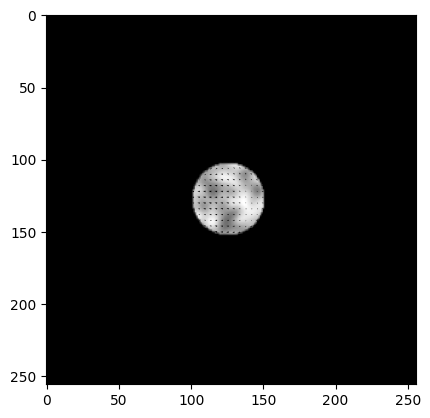

In [203]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

**Answers:**

(In order to see all the examples just change the variables horiz_displacement,
vert_displacement,  switch_image and add_noise and re-run the notebook)

Fixing `sigma = 2`.
- The estimated parameters with block matching : `(c, d) = [10.0, 1.0]`
- The estimated parameters with optic flow : `(c, d) = [8.87769159890468 0.9618313852001763]`

  In this case the block matching method performs much better than optic flow.

Lets compare all methods when we have non integer values of displacement. Fixing `(c, d) = [7.5, -2.5]`.
- Median of gradient : `(c, d) = [7.45, -3.17]`
- Least Squares : `(c, d) = [7.63, -7.94]`
- Block matching :  `(c, d) = [7.0, -3.0]`
- Optic flow : `(c, d) = [6.81, -2.92]`

  Comparing all the methods, the median of gradient gave the best result among all.
